## Hierarchical topic regression model

In [2]:
using Distributions, StatsFuns, StatsBase, DataFrames, LogTopReg
import Lazy.@>, Lazy.@>>, Lazy.@as

In [3]:
σ_μ = 1.0;
σ = 0.5;
σ_β = 0.5;

n = 200;
p = 2;
nd = repeat([50],inner=[n]);
K = 3;
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
softmax(μ)

3-element Array{Float64,1}:
 0.638548 
 0.30222  
 0.0592325

In [4]:
β

3×2 Array{Float64,2}:
  0.257267   0.280352
 -0.0838497  0.437247
 -0.319215   0.330196

In [5]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> vcat( hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))',
    rand(Multinomial(50,softmax(1:K.==j)),nk[j,i]), rand(Multinomial(50,softmax(K:-1:1.==j)),nk[j,i]) ), 1:K)...);
end

In [7]:
pss = VectorPosterior(PoissonPosterior(0.1,0.1),2,DirMultPosterior(K,1.0),2);
@time fit = topiclmm(y,X,pss,K,report_loglik=true);
ns = length(fit[:τ]);

127.528068 seconds (1.13 G allocations: 46.030 GB, 3.90% gc time)


In [9]:
using Gadfly

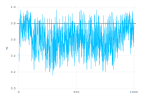

In [10]:
plot(y=fit[:τ]./(fit[:τ]+1),yintercept=[(σ_μ^2)/(σ_μ^2 + σ^2)],Geom.line,Geom.hline(color=colorant"black"))

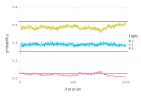

In [11]:
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=softmax(μ),
Geom.line,Geom.hline(color=colorant"black"))

In [13]:
warmup = 100;

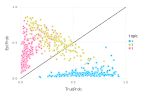

In [23]:
θpost1 = Float64[rand(topicpd(fit[:topic][i,j][1]))[1] for j=(warmup+1):ns, i=1:K];
ord = sortperm(vec(mean(θpost1,1)));
phat = @> mapslices(softmax,fit[:η][:,:,(warmup+1):ns],1) mean(3) getindex(ord,:);
pt = mapslices(softmax,η,1);
pdat = DataFrame(TrueProb=pt[:],EstProb=phat[:],RawProb=nk[:]./nd[1],topic=repeat(map(string,1:K),outer=[n]))
plot(layer(pdat,x="TrueProb",y="EstProb",color="topic",Geom.point),
layer(x=[0.,1],y=[0.,1],Theme(default_color=colorant"black"),Geom.line))

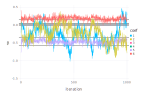

In [35]:
bdat = DataFrame(β = vec( refβ(fit[:β][:,ord,:],fit[:μ][ord,:]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),coef = repeat(map(string,1:(K*p)),outer=[ns]))
plot(bdat,y="β",x="iteration",color="coef",yintercept=vec(refβ(β',μ)),Geom.line,Geom.hline(color=colorant"black"))